In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
file_path = "case1Data.csv"
df = pd.read_csv(file_path)

In [4]:
correlation_matrix = df.corr()
correlation_with_y = correlation_matrix["y"].abs().sort_values(ascending=False)

high_corr_features = correlation_with_y[correlation_with_y > 0.3].index.tolist()
high_corr_features.remove("y")


In [5]:
df_high_corr = df[high_corr_features + ["y"]]
knn_imputer = KNNImputer(n_neighbors=5)
df_high_corr_imputed = pd.DataFrame(knn_imputer.fit_transform(df_high_corr), columns=df_high_corr.columns)
df.update(df_high_corr_imputed)

In [6]:
X = df[high_corr_features]
y = df["y"]


In [7]:

ridge = Ridge(alpha=1.0)

In [8]:
rmse_scores = np.sqrt(-cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error'))

In [9]:
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

Mean RMSE: 50.81
Standard Deviation of RMSE: 10.09


In [10]:
param_grid = {"alpha": np.logspace(-3, 3, 10)}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [11]:
best_ridge = grid_search.best_estimator_
best_alpha = grid_search.best_params_["alpha"]

In [12]:
rmse_scores = np.sqrt(-cross_val_score(best_ridge, X, y, cv=5, scoring='neg_mean_squared_error'))

In [13]:
print(f"Best Alpha: {best_alpha}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

Best Alpha: 46.41588833612773
Mean RMSE: 49.28
Standard Deviation of RMSE: 10.74


# normalize data as in w2_e1

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

In [21]:
def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

In [20]:
X = df.drop('y', axis=1)

X_imputed_mean = X.fillna(X.mean())

# check if there are any columns with zero variance
variance = np.var(X_imputed_mean, axis=0)
zero_var_cols = np.where(variance == 0)[0]
print('Zero variance columns:', zero_var_cols)

# drop columns with zero variance
X_imputed_mean = X_imputed_mean.drop(X_imputed_mean.columns[zero_var_cols], axis=1)
print('Columns dropped:', X.columns[zero_var_cols])

[n, p] = np.shape(X_imputed_mean)

Zero variance columns: [96]
Columns dropped: Index(['C_02'], dtype='object')


In [22]:
X_pre = X_imputed_mean - np.mean(X_imputed_mean,axis=0)
y_pre = y - np.mean(y,axis=0)

# And then we normalize the variables of the data matrix to unit length 
X_pre,d = normalize(X_pre)

k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))
    
for i in range(k):
    betas[:, i] = ridgeMulti(X_pre, lambdas[i], p, y_pre)

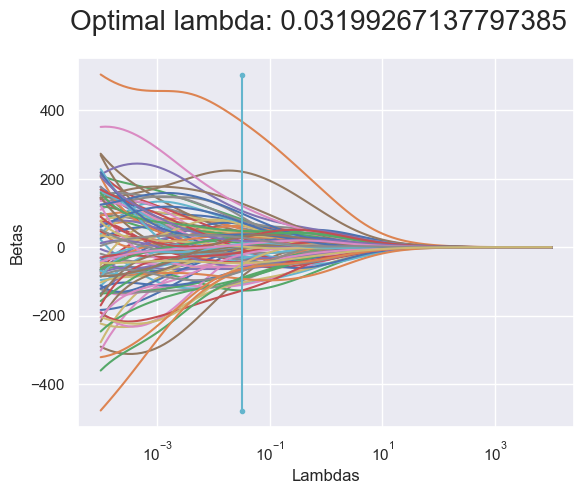

In [29]:
K = 10

#Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

#Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-4, 4, k)
RMSE = np.zeros((10, 100))

for i in range(1, K+1):
    #Select the train/test data in this fold
    XTrain = X_imputed_mean[I != i]
    yTrain = y[I != i]
    XTest = X_imputed_mean[I == i]
    yTest = y[I == i]
    
    #Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest-mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest-mu; # use the mean value of the training data to center the test data
    
    XTrain,d = normalize(XTrain) # normalize training data
    XTest = XTest / d # normalize test data using euclidian lengths of train data columns
    
    
    #Fit ridgeregression
    for j in range(100):
        #beta = Ridge(alpha=lambdas[j]).fit(XTrain, yTrain).coef_
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        RMSE[(i - 1), j] = np.sqrt(np.mean((yTest - np.matmul(XTest, beta)) ** 2))

        
meanRMSE = np.mean(RMSE, axis = 0)
jOpt = np.argsort(meanRMSE)[0]
lambda_OP = lambdas[jOpt]


# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

In [33]:
model = Ridge(alpha=lambda_OP)

X_norm, mu = centerData(X_imputed_mean)
X_norm = X_norm / d

y_centered, _ = centerData(y)

rmse_scores = np.sqrt(-cross_val_score(model, X_norm, y_centered, cv=5, scoring='neg_mean_squared_error'))

print(f"Mean RMSE: {rmse_scores.mean():.2f}")


Mean RMSE: 32.60
